In [1]:
using JLD2
using PythonPlot
include("MDPModelFunctions2.jl")
using DataFrames

    CondaPkg Found dependencies: /Users/erussek/.julia/packages/PythonCall/wXfah/CondaPkg.toml
    CondaPkg Found dependencies: /Users/erussek/.julia/packages/PythonPlot/KcWMF/CondaPkg.toml
    CondaPkg Dependencies already up to date


In [28]:
include("shimi_all_parameter_search_coarse.jl")

N_Jobs_Total: 9600
N_Runs: 480
Job: 1, N_Quanta: 2, epsilon: 0.99, NT_per_Second: 25, mem_slope: 0.025
Job: 2, N_Quanta: 2, epsilon: 0.99, NT_per_Second: 50, mem_slope: 0.025
Job: 3, N_Quanta: 2, epsilon: 0.99, NT_per_Second: 100, mem_slope: 0.025
Job: 4, N_Quanta: 2, epsilon: 0.99, NT_per_Second: 200, mem_slope: 0.025
Job: 5, N_Quanta: 2, epsilon: 0.99, NT_per_Second: 400, mem_slope: 0.025


LoadError: LoadError: InterruptException:
in expression starting at /Users/erussek/Dropbox/Griffiths_Lab_Stuff/Code/Memory_Models/shimi_all_parameter_search_coarse.jl:71

In [29]:
9600/300

32.0

In [14]:
1360/5

272.0

In [22]:
# experiment 1....

# row is 2 obj vs 4 obj
# col is 2 pre-cue, 2 neutral, 2 retro-cue, 2 neutral, 4 pre-cue, 4 neutral, 4 retro-cue, 4 neutral

exp1_cowan_k_true_7_yr = [1.16 1.14 1.13 1.02 2.80 .91 1.30 .96]'
exp1_cowan_k_true_adult = [1.98 1.94 1.97 1.95 3.87 2.66 3.64 2.87]'

# experiment 2 - 4 objects
# col is IM cued, IM neutral, VSTM cued, VSTM neutral

exp2_cowan_k_true_7_yr = [1.55 1.16 1.00 0.69]'
exp2_cowan_k_true_adult = [3.54 2.58 3.58 2.65]'

# experiment 3

# Load 3 cued, Load 3 Neutral, Load 6 cued, Load 6 neutral
IM_true_7_yr = [1.44 1.27 1.82 0.88]
Short_VSTM_true_7_yr = [1.14 0.77 NaN NaN]
Long_VSTM_true_7_yr = [1.19 0.90 NaN NaN]

exp3_cowan_k_true_7_yr = [IM_true_7_yr; Short_VSTM_true_7_yr; Short_VSTM_true_7_yr]


IM_true_adult = [2.63 2.41 4.80 2.46]
Short_VSTM_true_adult = [2.75 2.38 3.97 2.15]
Long_VSTM_true_adult = [2.76 2.30 3.65 1.75]

exp3_cowan_k_true_adult = [IM_true_adult; Short_VSTM_true_adult; Short_VSTM_true_adult]


3×4 Matrix{Float64}:
 2.63  2.41  4.8   2.46
 2.75  2.38  3.97  2.15
 2.75  2.38  3.97  2.15

In [23]:
## Specify parameters for each job and load all results...
# 21 epsilon values

eps_vals = collect(.99:-.1:.01)
N_eps = length(eps_vals)

# quanta values
q_vals = collect(2:10:102)
N_q = length(q_vals)

mem_slopes = [.025, .05, .1, .2, .4, .8]
N_ms = length(mem_slopes)

# re-run with new values so we can see some concavity...
NT_vals = [25, 50, 100, 200, 400, 800, 1600, 3200] # run w these now... 
N_nt = length(NT_vals)

8

In [24]:

function load_results(epsilon, N_Quanta, NT_per_Second, mem_slope; exp_num = 2, on_cluster = false)
    
    if on_cluster
        to_save_folder = "/home/erussek/projects/Memory_Models/shimi_all_parameter_search_coarse2"
    else
        to_save_folder = "/Users/erussek/Dropbox/Griffiths_Lab_Stuff/code/Memory_Models/shimi_all_parameter_search_coarse2/exp$(exp_num)"
    end
    
    local file_name = "N_Quanta_$(N_Quanta)_epsilon_$(epsilon)_NT_per_Second_$(NT_per_Second)_memslope_$(mem_slope).jld2"
    
    local full_file_path = joinpath(to_save_folder,file_name)

    res = load(full_file_path)
    
    return res["job_res_$(exp_num)"]
end

function format_res_cowan_k(res; exp_num = 1)
    
    if exp_num == 1
    
        # row is 2 obj vs 4 obj
        # col is pre-cue, neutral, retro-cue, neutral
        
        part_pcorr = res[:,:,end];
        model_cowan_p_corr = [part_pcorr; part_pcorr[2,:]']'
        model_cowan_k_mtx = cowan_k(model_cowan_p_corr, 2)
        model_cowan_k_mtx[2,:] = cowan_k(model_cowan_p_corr[2,:], 4)
        
        model_cowan_k = [model_cowan_k_mtx[1,:]' model_cowan_k_mtx[2,:]']';#[model_cowan_k_mtx[1,:] model_cowan_k_mtx[2,:]]
    elseif exp_num == 2
        
        # IM cued, IM neutral, VSTM cued, VSTM neutral - need to adjust from what it was saved as
        
        (p_short_neutral, p_short_retro, p_long_neutral, p_long_retro) = res
        (p_short_neutral, p_short_retro, p_long_neutral, p_long_retro) = (p_short_neutral[end], p_short_retro[end], p_long_neutral[end], p_long_retro[end])
        model_cowan_k = cowan_k([p_short_retro p_short_neutral p_long_retro p_long_neutral],4)'
        
    else
        
        (p_IM_neutral, p_IM_retro, p_VSTM_neutral, p_VSTM_retro, p_Long_VSTM_neutral, p_Long_VSTM_retro) = res
        (p_IM_neutral, p_IM_retro, p_VSTM_neutral, p_VSTM_retro, p_Long_VSTM_neutral, p_Long_VSTM_retro) = (p_IM_neutral[:,end], p_IM_retro[:,end], p_VSTM_neutral[:,end], p_VSTM_retro[:,end], p_Long_VSTM_neutral[:,end], p_Long_VSTM_retro[:,end])


        # Load 3 cued, Load 3 Neutral, Load 6 cued, Load 6 neutral
        IM_model = [cowan_k(p_IM_retro[1],3) cowan_k(p_IM_neutral[1],3) cowan_k(p_IM_retro[2],6) cowan_k(p_IM_neutral[2], 6)]
        Short_VSTM_model = [cowan_k(p_VSTM_retro[1],3) cowan_k(p_VSTM_neutral[1],3) cowan_k(p_VSTM_retro[2],6) cowan_k(p_VSTM_neutral[2], 6)]
        Long_VSTM_model = [cowan_k(p_Long_VSTM_retro[1],3) cowan_k(p_Long_VSTM_neutral[1],3) cowan_k(p_Long_VSTM_retro[2],6) cowan_k(p_Long_VSTM_neutral[2], 6)]

        # 3 x 4
        model_cowan_k = [IM_model; Short_VSTM_model; Long_VSTM_model]  
        
    end
        
    return model_cowan_k
    
end    

function load_cowan_k(epsilon, N_Quanta, NT_per_Second, mem_slope; exp_num = 2, on_cluster = false)
    
    res = load_results(epsilon, N_Quanta, NT_per_Second, mem_slope; exp_num = exp_num, on_cluster = false)
    
    model_cowan_k = format_res_cowan_k(res; exp_num = exp_num)
    
    return model_cowan_k
    
end


load_cowan_k (generic function with 1 method)

In [25]:
mse_res = Dict()
for exp_num in 1:3
    mse_res[exp_num] = Dict()
    mse_res[exp_num]["child"] = zeros(N_eps, N_q, N_nt, N_ms)
    mse_res[exp_num]["adult"] = zeros(N_eps, N_q, N_nt, N_ms)
end

for (ep_idx, epsilon) in enumerate(eps_vals)
    for (q_idx, N_Quanta) in enumerate(q_vals)
        for (nt_idx, NT_per_Second) in enumerate(NT_vals)
            for (ms_idx, mem_slope) in enumerate(mem_slopes)
            
                for exp_num = 1:3
                    
                    try

                        model_cowan_k = load_cowan_k(epsilon, N_Quanta, NT_per_Second, mem_slope; exp_num = exp_num, on_cluster = false)

                        if exp_num == 1

                            child_mse = sum((model_cowan_k .- exp1_cowan_k_true_7_yr).^2)
                            adult_mse = sum((model_cowan_k .- exp1_cowan_k_true_adult).^2)

                        elseif exp_num == 2

                            child_mse = sum((model_cowan_k .- exp2_cowan_k_true_7_yr).^2)
                            adult_mse = sum((model_cowan_k .- exp2_cowan_k_true_adult).^2)

                        else

                            child_sq_err = (model_cowan_k[:] .- exp3_cowan_k_true_7_yr[:]).^2
                            child_mse = sum(child_sq_err[.!isnan.(child_sq_err)])
                            adult_mse = sum((model_cowan_k .- exp3_cowan_k_true_adult).^2)

                        end

                        mse_res[exp_num]["child"][ep_idx, q_idx, nt_idx, ms_idx] = child_mse
                        mse_res[exp_num]["adult"][ep_idx, q_idx, nt_idx, ms_idx] = adult_mse
                        
                    catch
                        
                        print("$(exp_num), $(epsilon), $(N_Quanta), $(NT_per_Second), $(mem_slope)")
                        
                        mse_res[exp_num]["child"][ep_idx, q_idx, nt_idx, ms_idx] = NaN
                        mse_res[exp_num]["adult"][ep_idx, q_idx, nt_idx, ms_idx] = NaN
                        
                    end
                    
                end

            end
        end
    end
end

# aggregate accross experiments
child_mse_all =  mse_res[1]["child"] + mse_res[2]["child"] + mse_res[3]["child"];
adult_mse_all =  mse_res[1]["adult"] + mse_res[2]["adult"] + mse_res[3]["adult"];

In [26]:
# for child and adult, get the min value and best parameter for each hyperparam

best_mse_child = zeros(N_nt, N_ms)
best_eps_child = zeros(N_nt, N_ms)
best_q_child = zeros(N_nt, N_ms)

best_mse_adult = zeros(N_nt, N_ms)
best_eps_adult = zeros(N_nt, N_ms)
best_q_adult = zeros(N_nt, N_ms)

for nt_idx = 1:N_nt
    for ms_idx = 1:N_ms
        
        this_child_mse = child_mse_all[:,:,nt_idx,ms_idx]
        best_mse_child[nt_idx, ms_idx] = minimum(this_child_mse)
        min_idx = argmin(this_child_mse)
        best_eps_child[nt_idx,ms_idx] = min_idx[1]
        best_q_child[nt_idx,ms_idx] = min_idx[2]

        
        this_adult_mse = adult_mse_all[:,:,nt_idx,ms_idx]
        best_mse_adult[nt_idx, ms_idx] = minimum(this_adult_mse)
        min_idx = argmin(this_adult_mse)
        best_eps_adult[nt_idx,ms_idx] = min_idx[1]
        best_q_adult[nt_idx,ms_idx] = min_idx[2]

    end
end

        
best_mse_all = best_mse_child + best_mse_adult


8×6 Matrix{Float64}:
 24.2804   5.80978  4.17238  6.06868  10.6822   9.67917
 14.6967   4.21096  3.86656  5.00072   7.16489  9.54199
  8.73077  4.17251  3.69961  3.59705   5.30521  8.94871
  7.87857  3.90222  3.90264  2.63206   3.90883  7.5779
  8.18908  3.8777   2.93516  1.8689    2.81272  5.40724
  8.88866  4.03061  2.36858  2.20888   2.43075  6.09434
  9.0006   6.02526  2.49305  1.85437   3.18222  5.95453
  9.60085  6.69819  2.87502  2.17306   3.81825  5.81266

In [27]:
top_linear_idxs = sortperm(best_mse_all[:])[1:10]
best_idxs = CartesianIndices(size(best_mse_all))[top_linear_idxs]
best_nt_vals = [NT_vals[bi[1]] for bi in best_idxs]
best_ms_vals = [mem_slopes[bi[2]] for bi in best_idxs]
top_hyp_df = DataFrame(NT = best_nt_vals, MS = best_ms_vals, val = sort(best_mse_all[:])[1:10])

Row,NT,MS,val
,Int64,Float64,Float64
1,1600,0.2,1.85437
2,400,0.2,1.8689
3,3200,0.2,2.17306
4,800,0.2,2.20888
5,800,0.1,2.36858
6,800,0.4,2.43075
7,1600,0.1,2.49305
8,200,0.2,2.63206
9,400,0.4,2.81272


In [20]:
best_idxs

10-element Vector{CartesianIndex{2}}:
 CartesianIndex(7, 4)
 CartesianIndex(5, 4)
 CartesianIndex(8, 4)
 CartesianIndex(6, 4)
 CartesianIndex(6, 3)
 CartesianIndex(6, 5)
 CartesianIndex(7, 3)
 CartesianIndex(4, 4)
 CartesianIndex(5, 5)
 CartesianIndex(8, 3)

In [21]:
mem_slopes

5-element Vector{Float64}:
 0.2
 0.2
 0.2
 0.2
 0.1

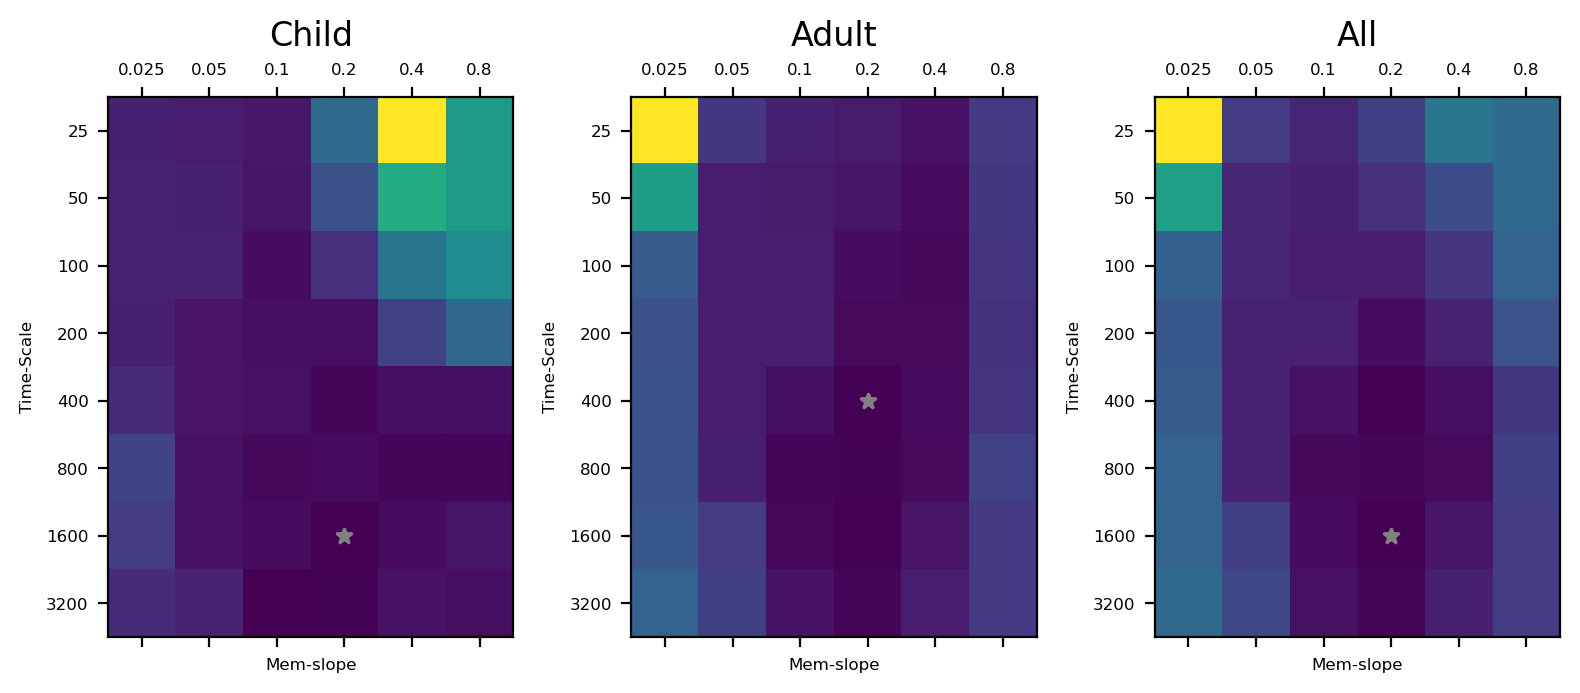

In [10]:
best_mse_child[isnan.(best_mse_child)] .= maximum(best_mse_child[.!isnan.(best_mse_child)])
best_mse_adult[isnan.(best_mse_adult)] .= maximum(best_mse_adult[.!isnan.(best_mse_adult)])
best_mse_all[isnan.(best_mse_all)] .= maximum(best_mse_all[.!isnan.(best_mse_all)])

fig,ax = subplots(1, 3, figsize=(8,6), dpi= 200, tight_layout=true)
ax[0].matshow(best_mse_child)
min_child_idx = argmin(best_mse_child)
ax[0].plot(min_child_idx[2]-1, min_child_idx[1]-1, '*', color = "gray")
ax[0].set_title("Child")

ax[1].matshow(best_mse_adult)
min_adult_idx = argmin(best_mse_adult)
ax[1].plot(min_adult_idx[2]-1, min_adult_idx[1]-1, '*', color = "gray")
ax[1].set_title("Adult")

ax[2].matshow(best_mse_all)
min_all_idx = argmin(best_mse_all)
ax[2].plot(min_all_idx[2]-1, min_all_idx[1]-1, '*', color = "gray")
ax[2].set_title("All")

for ax_idx = 0:2
    ax[ax_idx].set_yticks(0:N_nt-1)
    ax[ax_idx].set_yticklabels(NT_vals, fontsize=6)
    ax[ax_idx].set_ylabel("Time-Scale", fontsize=6)
    
    ax[ax_idx].set_xticks(0:N_ms-1)
    ax[ax_idx].set_xticklabels(mem_slopes, fontsize=6)
    ax[ax_idx].set_xlabel("Mem-slope", fontsize=6)
end

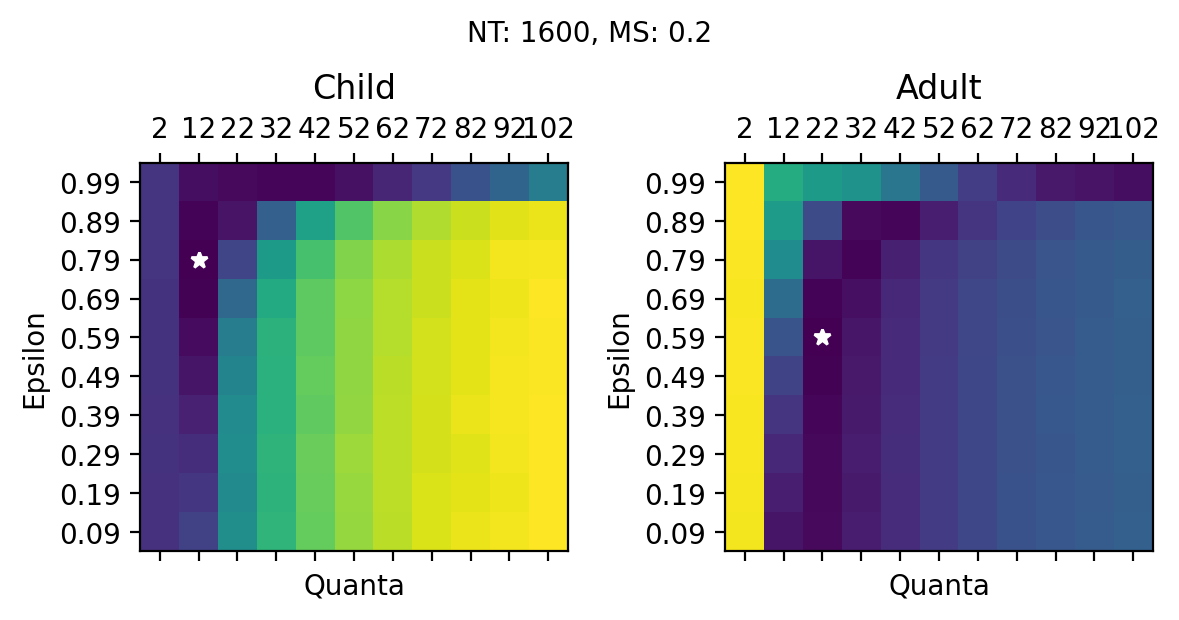

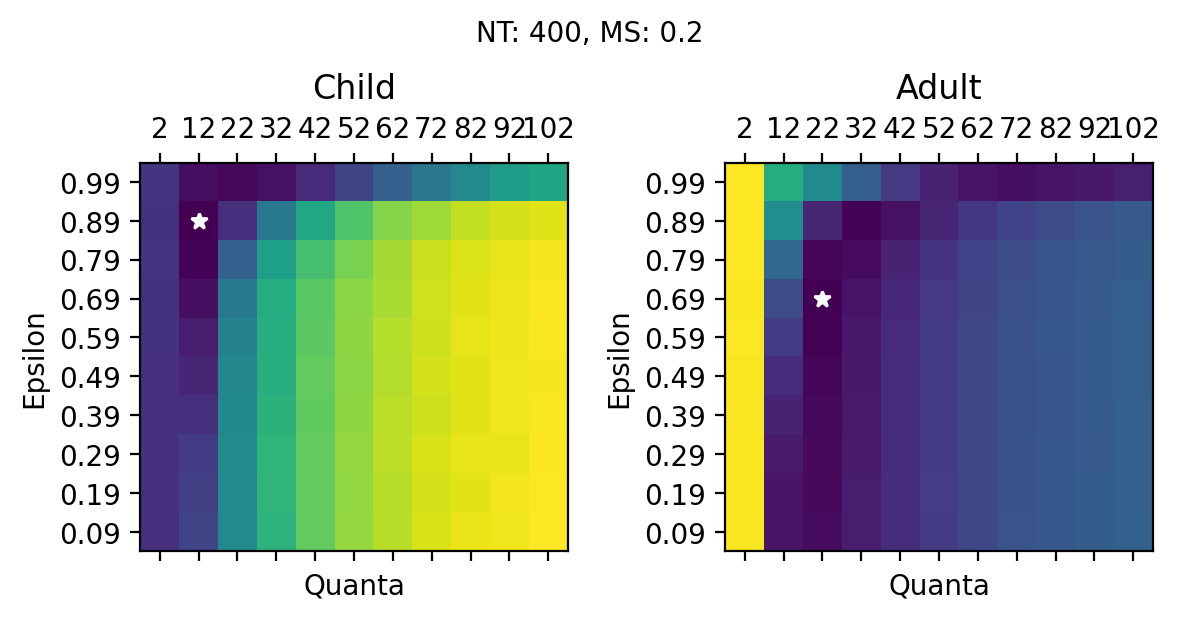

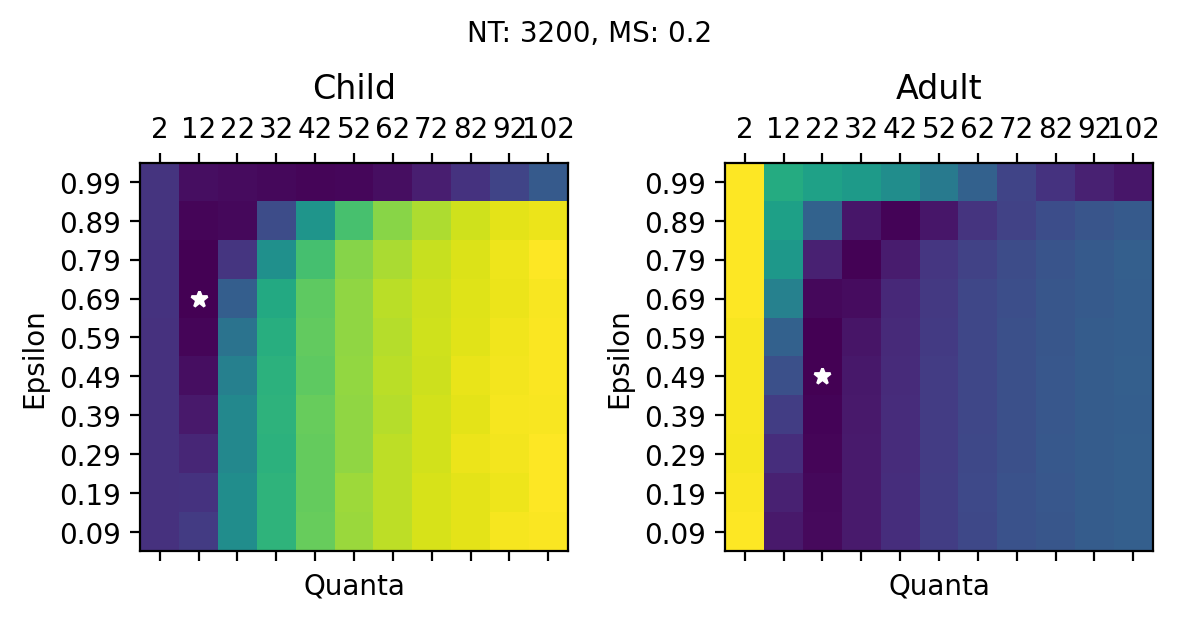

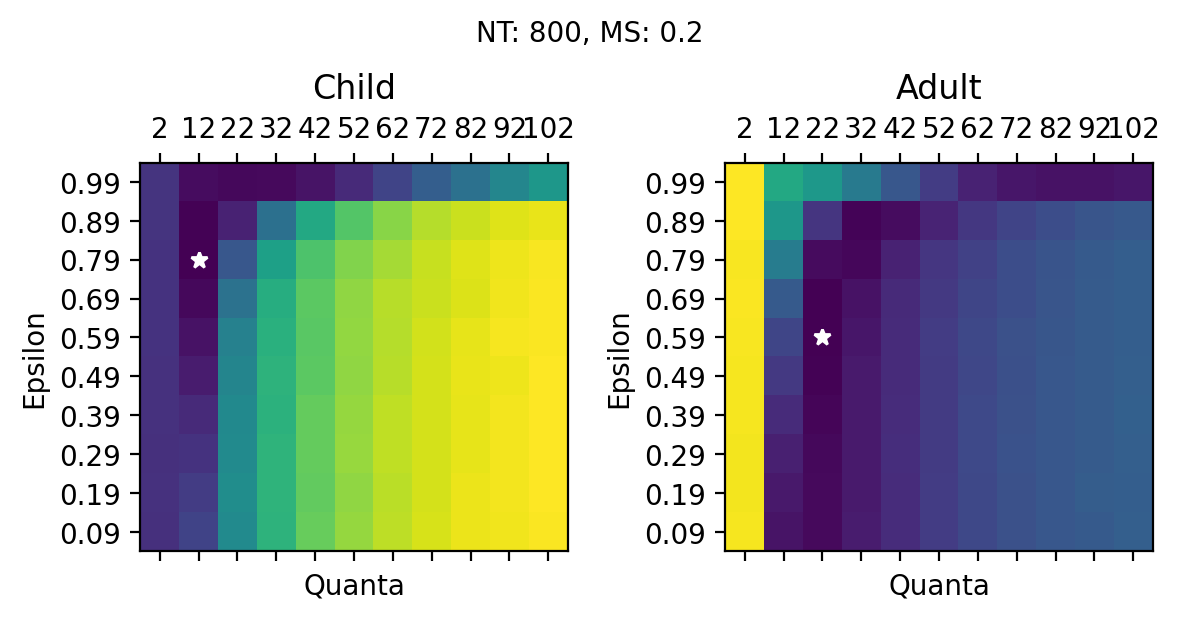

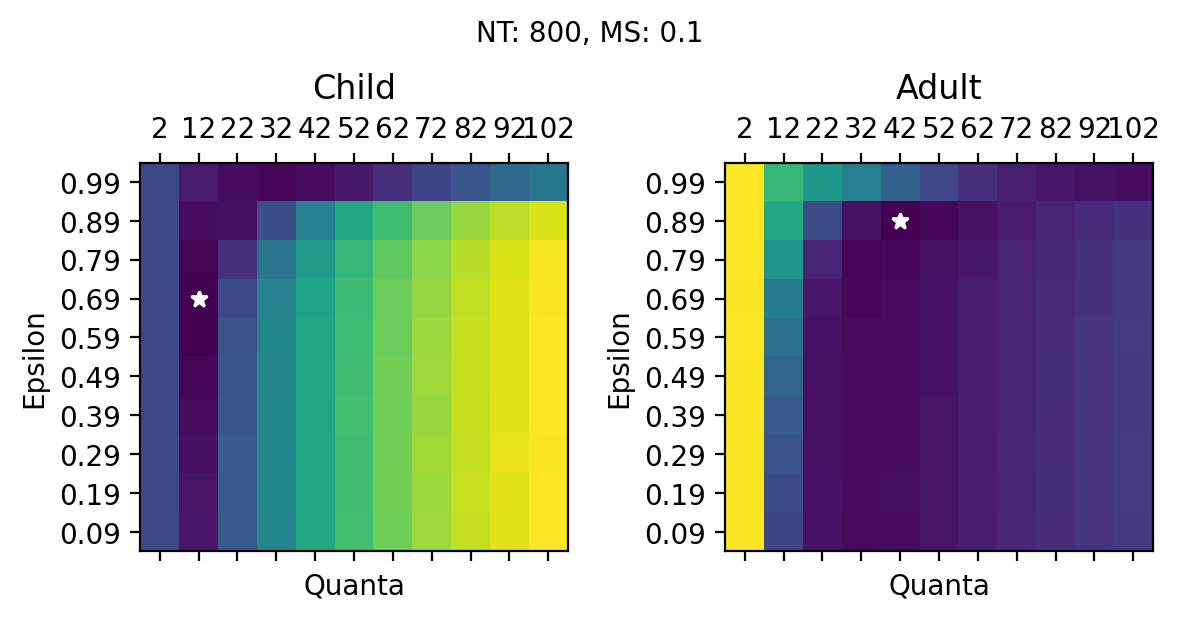

In [11]:
# plot error over params for each set


for i = 1:5
these_idxs = best_idxs[i]
nt_idx = these_idxs[1]
ms_idx = these_idxs[2]

this_NT = NT_vals[nt_idx]
this_ms = mem_slopes[ms_idx]


group_names = ["Child", "Adult"]

fig,ax = subplots(1, 2, figsize=(6,3), dpi= 200, tight_layout=false)

for group_idx = 0:1
    if group_idx == 0
        this_mse = child_mse_all
    else
        this_mse = adult_mse_all
    end


    ax[group_idx].matshow(this_mse[:, :, nt_idx, ms_idx])

    ax[group_idx].set_yticks(0:N_eps-1)
    ax[group_idx].set_yticklabels(eps_vals, fontsize=10)
    ax[group_idx].set_ylabel("Epsilon", fontsize=10)

    ax[group_idx].set_xticks(0:N_q-1)
    ax[group_idx].set_xticklabels(q_vals, fontsize=10)
    ax[group_idx].set_xlabel("Quanta", fontsize=10)


    # find the minimum index, 
    min_idx = argmin(this_mse[:,:,nt_idx, ms_idx])

    ax[group_idx].plot(min_idx[2]-1, min_idx[1]-1, '*', color = "white")
    ax[group_idx].set_title(group_names[group_idx+1])
    fig.suptitle("NT: $(this_NT), MS: $(this_ms)", fontsize = 10)
end
end